In [1]:
!git clone https://github.com/meisamrf/ivhc-estimator

Cloning into 'ivhc-estimator'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [2]:
cd ./ivhc-estimator/Python/libs

/content/ivhc-estimator/Python/libs


In [3]:
!python ./setup.py install

running install
running build
running build_ext
building 'ivhc' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c ivhcNoiseEst.cpp -o build/temp.linux-x86_64-3.7/ivhcNoiseEst.o -std=c++11
creating build/lib.linux-x86_64-3.7
x86_64-linux-gnu-g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.7/ivhcNoiseEst.o -L/usr/local

In [4]:
import numpy as np
import skimage.color
import ivhc

def imnest_ivhc(image, max_poly_deg=5):

    '''
    # imnest_ivhc(A)
    #   A can be an M-by-N (grayscale image) or M-by-N-by-3 (rgb color image)
    #   array.  A cannot be an empty array or very small matrix.
    #   max_poly_deg is the max of degree for polynomial regression 
    #  OUTPUTS:
    #   sigma_p is variance of noise in the Y channel at highest rank noise
    #   representative cluster. Under signal-independent noise, sigma_p
    #   estimates the standard deviation of noise. Under signal-dependent
    #   noise, sigma_p is likely to be the peak of the noise. However, the more
    #   accurate peak is estimated by var_nlf.
    # 
    #   sigma_o = sigma_p*gamma, where gamma is the degree of processing. When
    #   the noise is white, gamma = 1;
    # 
    #   var_nlf is the noise level (variance) function
    #
    '''

# parse input parameters 
    if type(image) != np.ndarray:
       image = np.array(image)

    if image.ndim == 3:
        ycbcr = skimage.color.rgb2ycbcr(image)
        gray_image = np.float32(ycbcr[:,:,0])
    elif image.ndim == 2:
        gray_image = image
    else:
        print('error in image type')
        return None

    if gray_image.dtype == np.uint8:
        gray_image = np.float32(gray_image)
    elif gray_image.dtype == np.float32 or gray_image.dtype == np.float64:
        gray_image = np.float32(gray_image)
        if np.max(gray_image)<=1.0:
            gray_image = gray_image*255.0
    else:    
        print('error in image dtype')
        return None
    
    # if (gray_image.shape[0]<128 or gray_image.shape[1]<128):
    #     print('Too Small Image')

    # if (gray_image.shape[0]>3840 or gray_image.shape[1]>3840):
    #     error('Image size is not supported') 


    # call function of IVHC
    nlf = np.zeros((3*256,), np.float32)
    # address column-major order
    gray_image = np.transpose(gray_image.copy())
    [sigma_p, sigma_o, nlf_len] = ivhc.run(gray_image, nlf)
    nlf = nlf[0:nlf_len]
    # cluster intensity
    clusters_iy = nlf[0::3]
    # binary weighting 
    clusters_bw = nlf[1::3]
    clusters_bw = clusters_bw/min(clusters_bw)
    # binary weighting 
    clusters_var = nlf[2::3]

    # ---- NLF regression -------
    # normalize
    nlf_v = clusters_var/(sigma_p*sigma_p)
    nlf_i = clusters_iy/255.0

    nlf_i_ext = np.concatenate((nlf_i, nlf_i[clusters_bw>1]))
    nlf_v_ext = np.concatenate((nlf_v, nlf_v[clusters_bw>1]))

    sort_idx= np.argsort(nlf_i_ext)
    nlf_i_sort = nlf_i_ext[sort_idx]
    nlf_v_sort = nlf_v_ext[sort_idx]

    max_poly_deg = int(np.floor(max_poly_deg/2)+1)

    if (len(nlf_v_sort)>1):
        last_mse = 1
        for k in range(0,max_poly_deg+1):
            est_pol = np.polyfit(nlf_i_sort, nlf_v_sort, min(1+k*2,len(nlf_i_sort)-1))
            nlf_reg = np.polyval(est_pol, nlf_i_sort)
            mse = np.mean((nlf_reg-nlf_v_sort)**2)
            if (mse<0.002 or (last_mse-mse)/mse<0.5):
                break;
           
            last_mse = mse
    
        nlf_i_sort = np.sort(nlf_i)
        nlf_reg = np.polyval(est_pol, nlf_i_sort)
    else:
        nlf_reg = nlf_v
        nlf_i_sort = np.sort(nlf_i)
    
    v = np.concatenate(([nlf_reg[0]], nlf_reg, [nlf_reg[-1]]))
    x = np.concatenate(([0], nlf_i_sort, [1]))
    var_nlf = np.interp(np.arange(0, 256)/255.0, x, v)*sigma_p*sigma_p

    return [sigma_p, sigma_o, var_nlf]


In [16]:
#Splicing implementation :

import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def estimate_noise(image_path):
    img = cv2.imread(image_path)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
    num_tiles_x = 4
    num_tiles_y = 5
    M = img.shape[0]//num_tiles_x
    N = img.shape[1]//num_tiles_y
    
    tiles = [img[x:x+M,y:y+N] for x in range(0,M*num_tiles_x,M) for y in range(0,N*num_tiles_y,N)]
    # print([(x,x+M,y,y+N) for x in range(0,M*num_tiles_x,M) for y in range(0,N*num_tiles_y,N)])
    print(len(tiles))
    sigma_pair_array = []
    i = 0
    for tile in tiles:
        
        print(i)
        i = i + 1
        # plt.imshow(np.uint8(tile))
        # plt.show()
        
        [a,b,c] = imnest_ivhc(tile,2)
        print(a,b)
        sigma_pair_array.append((a,b))

    # return(sigma_pair_array)
    clf = IsolationForest(n_estimators=10, warm_start=True,contamination=0.1)
    clf.fit(sigma_pair_array) 

    outliers = clf.predict(sigma_pair_array)
    indices = [i for i, x in enumerate(outliers) if x == -1]
    print(indices)

    for index in indices:
      row = int(index/num_tiles_y)
      col = index%num_tiles_y
      print(row, col)
      img[row*M:row*M + M,col*N:col*N+N] = np.zeros((M,N))

    

    plt.imshow(np.uint8(img))
    plt.show()

In [17]:
cd ../../..

/


(640, 960, 3)
20
0
0.0 0.0
1
0.0 0.0
2
0.0 0.0
3
0.0 0.0
4
0.0 0.0
5
0.8067854046821594 1.8021252155303955
6
1.3261184692382812 2.6559371948242188
7
1.6439697742462158 2.421132802963257
8
0.9184362292289734 1.3773077726364136
9
0.6484975218772888 4.052714824676514
10
0.0 0.0
11
5.32412052154541 6.85017204284668
12
3.382025718688965 4.631548881530762
13
7.9865827560424805 10.705068588256836
14
0.0 0.0
15
1.753178596496582 2.137535810470581
16
0.0 0.0
17
1.9963270425796509 2.370511293411255
18
1.9725515842437744 2.304877519607544
19
0.9614092111587524 1.0853368043899536
[11, 13]
2 1
2 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


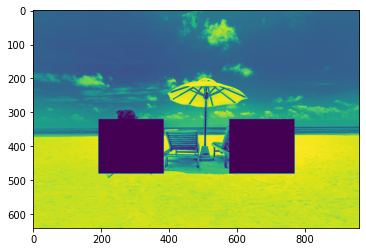

In [20]:
sigma_pair_array = estimate_noise("1_splice.jpg")

(1060, 1500, 3)
20
0
0.9807851910591125 0.9807851910591125
1
0.9335138201713562 0.9335138201713562
2
2.882063150405884 13.631244659423828
3
1.1301287412643433 1.4065580368041992
4
0.9802417159080505 1.0421271324157715
5
1.5279685258865356 2.5639307498931885
6
2.1911072731018066 2.839111804962158
7
2.837775230407715 6.236114025115967
8
2.0093135833740234 2.961784601211548
9
1.0041835308074951 1.0041835308074951
10
1.95490562915802 2.9155056476593018
11
0.9443604350090027 1.0407508611679077
12
1.4946167469024658 1.8504143953323364
13
1.6843478679656982 2.2596347332000732
14
0.9350862503051758 1.0569628477096558
15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


1.3013954162597656 1.7310256958007812
16
0.7897174954414368 0.817130982875824
17
0.8580887317657471 0.8580887317657471
18
2.6066746711730957 3.430176258087158
19
1.8655130863189697 2.4640817642211914
[2, 7]
0 2
1 2


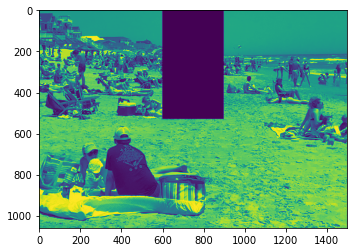

In [21]:


sigma_pair_array = estimate_noise("/content/2_splice.jpg")


(950, 1200, 3)
20
0
0.9359891414642334 2.0619618892669678
1
0.5744450688362122 1.9963816404342651
2
0.0 0.0
3
0.6458585262298584 1.83804190158844
4
0.0 0.0
5
0.9886804819107056 1.0202313661575317
6
0.7840632200241089 1.2286783456802368
7
0.0 0.0
8
2.0531961917877197 3.1401617527008057
9
1.0072118043899536 1.5219039916992188
10
0.6977077126502991 2.023395538330078
11
0.910897433757782 1.2668344974517822
12
0.0 0.0
13
0.0 0.0
14
0.0 0.0
15
0.6515323519706726 1.1865930557250977
16
0.0 0.0
17
0.7753733992576599 1.3211760520935059
18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


0.0 0.0
19
0.772571325302124 1.5214459896087646
[5, 8]
1 0
1 3


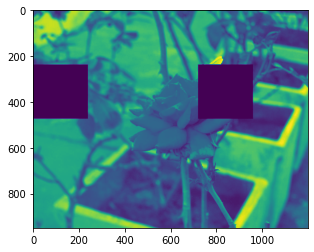

In [22]:
sigma_pair_array = estimate_noise("/content/3_splice.jpg")

(2821, 3761, 3)
20
0
0.0 0.0
1
0.0 0.0
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be p

0.0 0.0
3
0.0 0.0
4
0.0 0.0
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


0.0 0.0
6
0.0 0.0
7
0.0 0.0
8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


0.0 0.0
9
0.0 0.0
10
0.0 0.0
11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


0.0 0.0
12
2.077576160430908 11.070250511169434
13
0.0 0.0
14
0.0 0.0
15
0.0 0.0
16
0.0 0.0
17
1.2234523296356201 1.5864312648773193
18
0.0 0.0
19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


0.0 0.0
[12, 17]
2 2
3 2


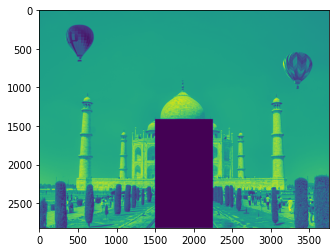

In [23]:
sigma_pair_array = estimate_noise("/content/4_splice.jpg")